# UK 10 year government bond yield

In [5]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMGamma
from omega_estimator import OmegaEstimatorGamma
from utils.find_cp import find_cp

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data/bond')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/bond')
FILE_PATH = os.path.join(DATA_PATH,'United Kingdom 10-Year Bond Yield Historical Data.csv')

## Import Data

In [7]:
df = pd.read_csv(FILE_PATH)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df = df.set_index('Date').resample('D').interpolate('linear')
data = df['Price'].values
dates = df.index.values

In [8]:
T = len(data)
data = data.reshape((T,1))

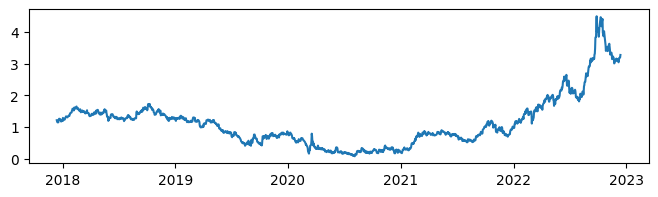

In [9]:
plt.subplots(figsize=(8,2))
plt.plot(dates,data)

## Define functions needed for the method: $m$, $\nabla m$

In [10]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

## Prior parameters

In [11]:
k_mu0 = 0
theta_mu0 = 1

k_Sigma0 = 50
theta_Sigma0 = 3


mu0 = np.asarray([[k_mu0], [theta_mu0]])

Sigma0 = np.eye(2)
Sigma0[0,0] = k_Sigma0
Sigma0[1,1] = theta_Sigma0

## Initialize estimator to find $\omega$

In [12]:
estimator = OmegaEstimatorGamma(data[:100], m ,grad_m, mu0, Sigma0)

In [13]:
omegas, costs = estimator.omega(1.0, lr = 0.0001, niter = 1000)

In [14]:
omega = omegas[-1]
print(omega)

0.049032557755708694


## Initialize model and CP prior

In [15]:
model = DSMGamma(data, m ,grad_m, omega, mu0, Sigma0, b = 20)

In [16]:
hazard = ConstantHazard(100)

## Run BOCD algorithm

In [17]:
%%time
R_DSM  = bocpd(data, hazard, model, K=50, verbose=True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
Processing observation #1100
Processing observation #1200
Processing observation #1300
Processing observation #1400
Processing observation #1500
Processing observation #1600
Processing observation #1700
Processing observation #1800
CPU times: user 7min 40s, sys: 2min 22s, total: 10min 2s
Wall time: 5min 10s


## Plots

In [18]:
events = np.flip(np.array(['2022-09-06', # Liz Truss sworn in
                   '2021-12-06', # Plan B measures
                   '2021-07-19', # Restriction end 
                   '2021-01-08', # Covid third wage in UK
                   '2020-04-15', # Covid first wage in UK
                   '2020-02-21', # First Covid case in EU
                   '2019-07-24', # Boris Johnson sworn in
                   '2019-05-24', # Theresa May resignation
                  ], dtype='datetime64'))

/tmp/ipykernel_1350/105826703.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


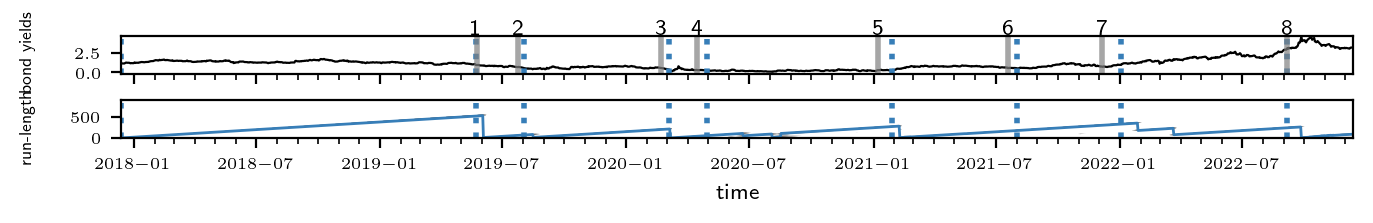

In [19]:
FILE_NAME = 'Bond.pdf'
R = R_DSM
cps = find_cp(R_DSM)
cp_color = CB_color_cycle[0]
import matplotlib.dates as mdates
x_lims = mdates.date2num([dates[0],dates[-1]])

with plt.rc_context(bundles.icml2022(column = 'full', ncols=3)):

    fig, ax = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [1,1]}, dpi = 200, figsize=(6.75, 1))
    ax[0].plot(dates, data[:,0],c='black',lw=0.8)
    
    ax[1].set_xlim([x_lims[0],x_lims[1]])
    ax[1].set_ylim([0,T/2])
    ax[1].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T])
    ax[1].plot(dates, np.argmax(R[1:],axis=1), c=cp_color, alpha=1, lw=1)

    for cp in cps:
        ax[0].axvline(dates[cp], c=cp_color, ls='dotted', lw=2)
        ax[1].axvline(dates[cp], c=cp_color, ls='dotted', lw=2)
    
    for i, event in enumerate(events):
        ax[0].axvline(event,c='grey', alpha = 0.7, lw= 2)
        ax[0].text(event, 5.5, i+1, fontsize = bundles.icml2022(column = 'full', ncols=2)['font.size'], horizontalalignment='center', verticalalignment='center')
        
    ax[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
    
    #for label in ax[1].get_xticklabels(which='major'):
    #    label.set(rotation=30, horizontalalignment='right')
    
    ax[1].set_xlabel('time')
    
    ax[0].set_ylabel('bond yields', size = 6)
    ax[1].set_ylabel('run-length', size = 6)
    
    
    ax[0].yaxis.set_label_coords(-0.07,0.6)
    ax[1].yaxis.set_label_coords(-0.07,0.3)
    
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

/tmp/ipykernel_1350/1292707074.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


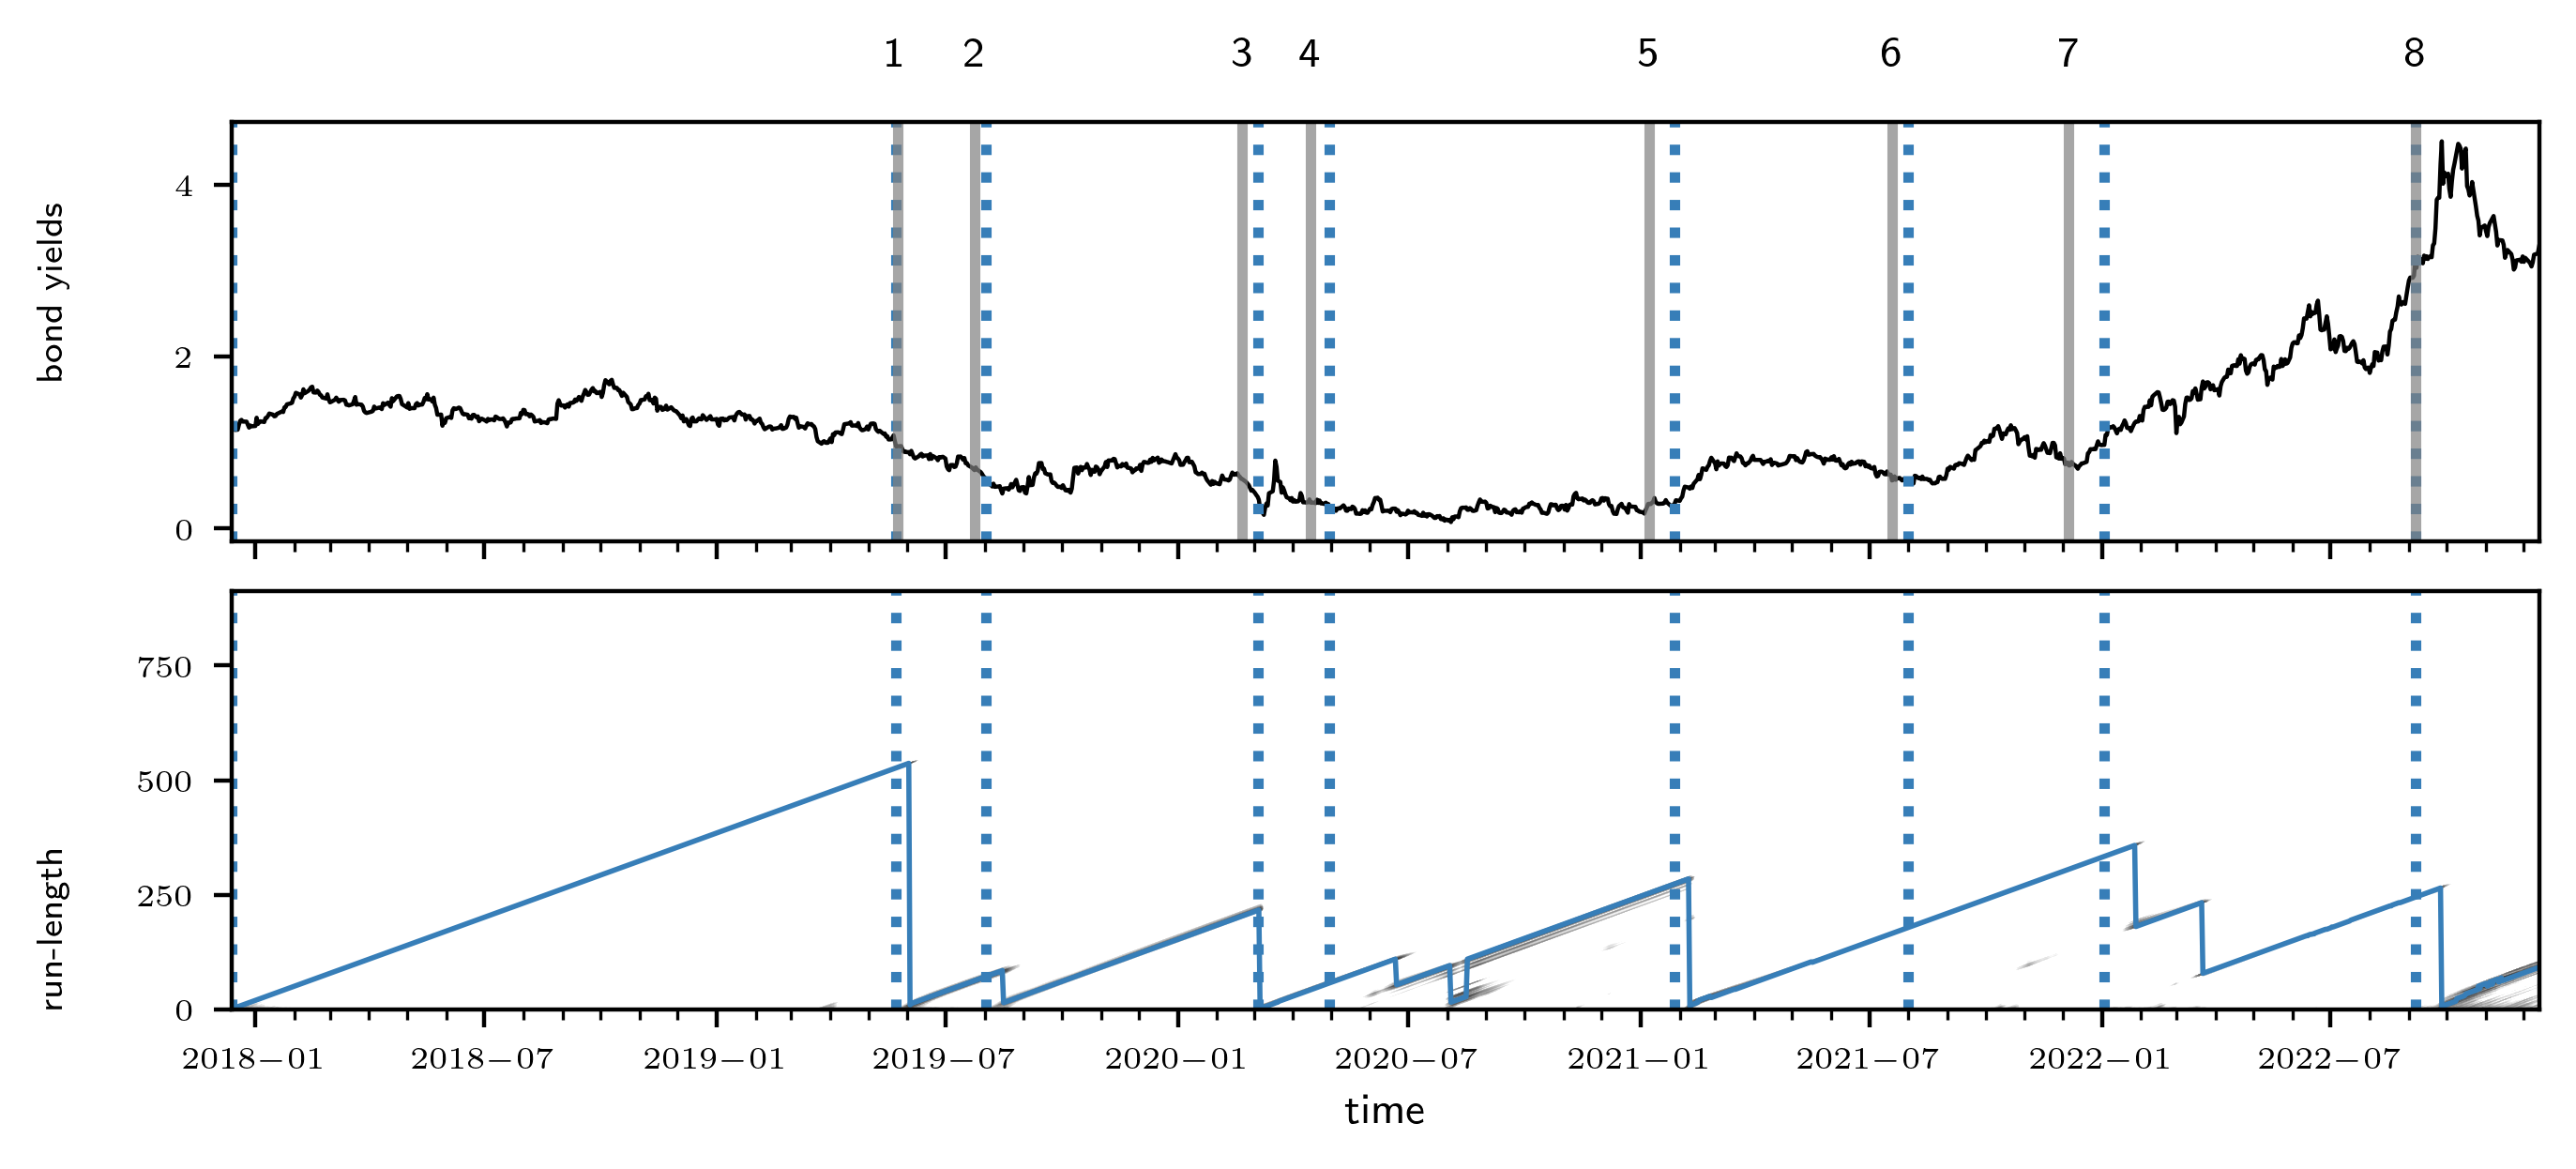

In [20]:
FILE_NAME = 'Bond.pdf'
R = R_DSM
cps = find_cp(R_DSM)
cp_color = CB_color_cycle[0]
import matplotlib.dates as mdates
x_lims = mdates.date2num([dates[0],dates[-1]])

with plt.rc_context(bundles.icml2022(column = 'full', ncols=3)):

    fig, ax = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [1,1]}, dpi = 400, figsize=(6.75, 3))
    ax[0].plot(dates, data[:,0],c='black',lw=0.8)
    
    ax[1].set_xlim([x_lims[0],x_lims[1]])
    ax[1].set_ylim([0,T/2])
    ax[1].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[x_lims[0],x_lims[1],0,T])
    ax[1].plot(dates, np.argmax(R[1:],axis=1), c=cp_color, alpha=1, lw=1)

    for cp in cps:
        ax[0].axvline(dates[cp], c=cp_color, ls='dotted', lw=2)
        ax[1].axvline(dates[cp], c=cp_color, ls='dotted', lw=2)
    
    for i, event in enumerate(events):
        ax[0].axvline(event,c='grey', alpha = 0.7, lw= 2)
        ax[0].text(event, 5.5, i+1, fontsize = bundles.icml2022(column = 'full', ncols=2)['font.size'], horizontalalignment='center', verticalalignment='center')
        
    ax[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
    
    #for label in ax[1].get_xticklabels(which='major'):
    #    label.set(rotation=30, horizontalalignment='right')
    
    ax[1].set_xlabel('time')
    
    #ax[0].set_ylabel('bond yields', size = 7)
    #ax[1].set_ylabel('run-length', size = 7)
    
    
    #ax[0].yaxis.set_label_coords(-0.07,0.6)
    #ax[1].yaxis.set_label_coords(-0.07,0.2)
    
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")